In [19]:
import sys
import math

import numpy as np

import paths
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils

import matplotlib.pyplot as plt

In [2]:
import importlib 
importlib.reload(paths)

<module 'paths' from 'C:\\Users\\Student\\Documents\\OTP\\paths.py'>

In [3]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

here is where you pick the latitude, index 0 = 26, index 1=-30 ect ect.... 

slice is take index 1 and 2 - need longitude info 

In [4]:
lat = lats[3]
lat_str = strf_utils.format_lat_lon(lat)

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

dont need to change this 

In [5]:
outputs_fp = f"{data_home}/ecco_data_minimal/{lat_str}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)

outputs = np.expand_dims(outputs[1, : ], 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (["time", "latitude"], outputs)}, coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})
outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -60
Data variables:
    moc       (time, latitude) float64 -13.44 -14.53 -6.054 ... 1.92 -15.98

In [6]:
date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('1992-01-16', '2017-12-16')


this is the tweaking cell
#
inputs 
mode - leave 
remoce seaon - this can be played with, can be done later 
moce trent - this can be played with, can be done later 
standards - leave 
lowpass - leave 

repshape the inputs - change, (you cna remove and add longitude)

In [8]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=True,
                              remove_trend=True,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"])                   #"longitude" +- 

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",                        
                               remove_season=True,                        #play around with this 
                               remove_trend=True,                        #play around with this 
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np
# Necessary step to do convolutions along the right axis with pytorch tensors! ### google later 
print(X.shape)
X = X.transpose(0,1)         #with long and time X = X.transpose(0,2,1)  

y = strength_np

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)
(312, 5)

Inputs shape: (312, 5)
Outputs shape: (312,)


test size smaller so can train on more, can mess about with that. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

Xt_train = t.tensor(X_train, device=device).double()
Yt_train = t.tensor(y_train, device=device).double()
Xt_test = t.tensor(X_test, device=device).double()
Yt_test = t.tensor(y_test, device=device).double()

device: cpu


In [10]:
from models import train, SimDataset, CNN1D, CNN2D, CNN3D

THIS ONE IS THE PLAY AROUND 

dropout = 0.2 max 0.5 
n pyre layer = 1 - 5 
mix layres = 1-5           - this can be 0 but then n pure has to be 1 
n features = has to be 5 but it can be palyed aroudn depednsing ont he tmep, if imput data is changed donty forget this 
channels = how many featyres are connected 2-5 
kernal size - change depening on what neural network wokring on, between 3-7 (imput keep coord number)

model = 


these are the hyper parameters                                                                        hyper parameters 

device: cpu
1651 parameters.


100%|██████████| 2500/2500 [00:09<00:00, 273.41it/s]


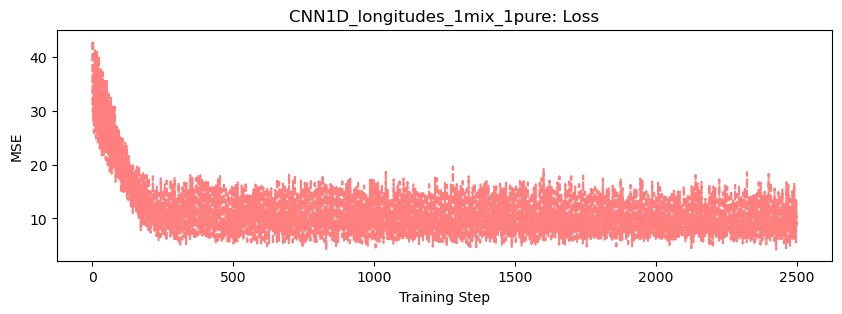

final loss: 10.35574151087766
model saved to G:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/saved_models/CNN1D_longitudes_1mix_1pure.pt
loss curve saved to G:/.shortcut-targets-by-id/1wvJjD0RMTujKYaXQapEiGk-Mx03_KSin/GTC\ecco_models/loss_curves/CNN1D_longitudes_1mix_1pure.png


In [11]:
dropout = 0.2
n_pure_layers = 2
n_mix_layers = 1
n_features = 5
n_channels = n_features * 5
kernel_size = 5                                                            #if in 2D (5,5) has to be two (sqaure vs rectangle) 

model = CNN1D.CNN1D(                                         #imput keep-coord number, for 2d CNN2D.CNN2D( 
    n_pure_layers=n_pure_layers, 
    n_mix_layers=n_mix_layers, 
    n_features=n_features, 
    n_channels=n_channels,
    kernel_size=kernel_size,
    dropout=dropout
).double()

save_dir = paths.MODELS_OUTPUT   ###'CNN1D_longitudes_1mix_1pure'  is the title 
loss1 = train.train_model(model, 'CNN1D_longitudes_1mix_1pure', Xt_train, Yt_train, save_dir=save_dir, conv_dim=1)   

#conv_dim same as dimentsions and keep coords, for 2d put conv=dim=2
#parwametres bellow 2000 for now 

look for the plato, you want a graph that contuines to go down, the down as close to zero, keeps learning 

device: cpu
device: cpu
Test R^2: 0.663
Test MSE: 10.583
Test RMSE: 3.253
Test MAE: 2.446


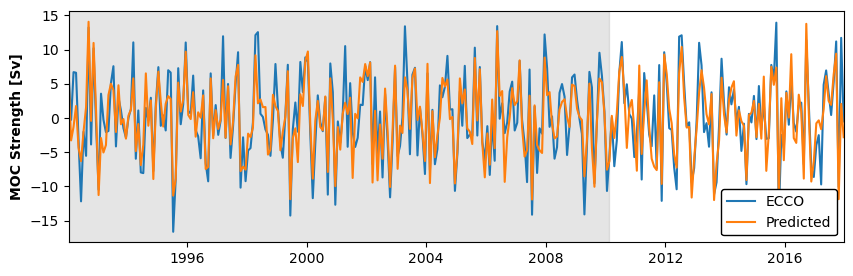

In [23]:
# Extracting all predictions in time order
train_set_pred = train.predict(model, 'CNN1D', Xt_train, Yt_train, conv_dim=1, save_dir=save_dir)   #conv_dim= numebr of dimen
test_set_pred = train.predict(model, 'CNN1D', Xt_test, Yt_test, conv_dim=1, save_dir=save_dir)     #conv_dim= numebr of dimen
all_preds = np.concatenate([train_set_pred, test_set_pred])

r2 = round(r2_score(test_set_pred, y_test), 3)
mse = round(mean_squared_error(test_set_pred, y_test), 3)
#rmse = round(root_mean_squared_error(test_set_pred, y_test), 3)
rmse = round(math.sqrt(mse), 3)
mae = round(mean_absolute_error(test_set_pred, y_test), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")           
print(f"Test MAE: {mae}")

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

test RMSE - 0.5 or as close to 
Test MSe - clsoe to zero as possible 
Test MAE - closer to zero as possible 

the more spread out the worst it is, linear better 
both test and train close to 1 as possible, 

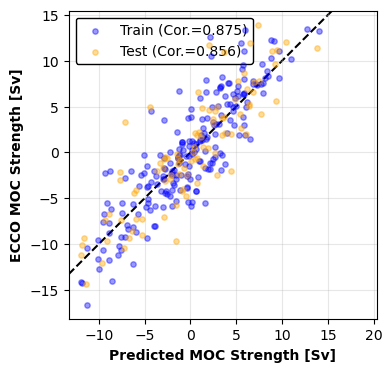

In [14]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(train_set_pred).squeeze()
y_pred_test = np.array(test_set_pred).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()